<a href="https://colab.research.google.com/github/NinelK/SA_DS_tutorial/blob/main/DS_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial:** Dynamical systems in neuroscience

### **Step 0**: Setup dependencies and import packages

In [1]:
%%capture
! pip install "dandi>=0.13.0"
! dandi download DANDI:000140/0.220113.0408
! pip install git+https://github.com/neurallatents/nlb_tools.git

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nlb_tools.nwb_interface import NWBDataset

#Decoding
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Ridge

# Part 3: Latent dynamics models

In recent years, progress in recording technologies enabled recordings of 100s to 1000s of neurons simultaneously.

At the same time, it was shown that neural population activity often has a low-dimensional structure: a low number of latent dynamical factors can explain a large fraction of neural variability. This finding is called a 'manifold hypothesis', and was proposed in [REF].



WRITE INTRO

Define Latent dynamics and Emission model

## Recurrent neural networks (RNNs)

Let us first consider the simplest, yet most important example of a non-linear discrete-time latent dynamical system: recurrent neural network. It is a go-to tool for modelling sequences in deep learning.

Latent dynamics: $$h_{t} = \sigma (V h_{t-1} + U x_t + b_h)$$
Emission model: $$o_t = W h_t + b_o $$


![RNN scheme (Wiki)](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2560px-Recurrent_neural_network_unfold.svg.png)


## **Exercise 3.1** Implement VanillaRNN



In [1]:
# class VanillaRNN(nn.Module):
#   def __init__(self, output_size, hidden_size, vocab_size, embed_size):
#     super(VanillaRNN, self).__init__()
#       ####################################################################
#     # Fill in missing code below (...),
#     # then remove or comment the line below to test your function
#     raise NotImplementedError("Vanilla RNN")
#     ####################################################################
#     self.hidden_size = ...
#     self.neuron_embeddings = ...
#     self.rnn = ...
#     self.fc = ...

#     self.hidden_size = hidden_size
#     self.word_embeddings = nn.Embedding(vocab_size, embed_size)
#     self.rnn = nn.RNN(embed_size, hidden_size, num_layers=2)
#     self.fc = nn.Linear(2*hidden_size, output_size)

#   def forward(self, inputs):
#     input = self.neuron_embeddings(inputs)
#     input = input.permute(1, 0, 2)
#     h_0 =  Variable(torch.zeros(2, input.size()[1], self.hidden_size)
#     output, h_n = self.rnn(input, h_0)
#     h_n = h_n.permute(1, 0, 2)
#     h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
#     logits = self.fc(h_n)

#     return logits

# ## Uncomment to test
# # sampleRNN = VanillaRNN(10, 50, 1000, 300)
# # print(sampleRNN)

SyntaxError: ignored

In [ ]:
# class VanillaRNN(nn.Module):
#   def __init__(self, output_size, hidden_size, vocab_size, embed_size):
#     super(VanillaRNN, self).__init__()
#       ####################################################################
#     # Fill in missing code below (...),
#     # then remove or comment the line below to test your function
#     raise NotImplementedError("Vanilla RNN")
#     ####################################################################
#     self.hidden_size = ...
#     self.neuron_embeddings = ...
#     self.rnn = ...
#     self.fc = ...

#     self.hidden_size = hidden_size
#     self.word_embeddings = nn.Embedding(vocab_size, embed_size)
#     self.rnn = nn.RNN(embed_size, hidden_size, num_layers=2)
#     self.fc = nn.Linear(2*hidden_size, output_size)

#   def forward(self, inputs):
#     input = self.neuron_embeddings(inputs)
#     input = input.permute(1, 0, 2)
#     h_0 =  Variable(torch.zeros(2, input.size()[1], self.hidden_size)
#     output, h_n = self.rnn(input, h_0)
#     h_n = h_n.permute(1, 0, 2)
#     h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
#     logits = self.fc(h_n)

#     return logits

# ## Uncomment to test
# # sampleRNN = VanillaRNN(10, 50, 1000, 300)
# # print(sampleRNN)

## **Exercise 3.2** Decoding behavior from sequential neural data using RNN

Seq2seq

### **Step 1:** Download the dataset. 

It is a classic monkey reach dataset with obstacles (MC_Maze) fro Churchland et al. ([more info](https://dandiarchive.org/dandiset/000140))

In [3]:
# for simplicity, we are using NLB tools 
dataset = NWBDataset("/content/000140/sub-Jenkins", "*train", 
                     split_heldout=False)

# to view the dataset, uncomment the next line
# dataset.data

### **Step 2**: Select the fields that we are going to use



The continuous data provided with the MC_Maze datasets includes:

* `cursor_pos` - x and y position of the cursor controlled by the monkey
* `eye_pos` - x and y position of the monkey's point of gaze on the screen, in mm
* `hand_pos` - x and y position of the monkey's hand, in mm
* `hand_vel` - x and y velocities of the monkey's hand, in mm/s, computed offline using np.gradient
* `spikes` - spike times binned at 1 ms

Here we will try picking a single aspect of behavior (e.g. `hand_vel`) and decoding it from the spike data `spikes` using an RNN decoder.

In [4]:
input_key = 'spikes'
output_key = 'hand_vel'

### **Step 3:** Trialize and visualize the data
Surprisingly autonomous -> movement onset

In [150]:
# Extract neural data and lagged hand velocity
trial_length = 500
trial_data = dataset.make_trial_data(align_field='move_onset_time', 
                                     align_range=(-130, -130+trial_length))
lagged_trial_data = dataset.make_trial_data(align_field='move_onset_time', 
                                      align_range=(0, 0+trial_length))

# trial_data['trial_id'].to_numpy().reshape((-1,trial_length))
inputs = trial_data[input_key].to_numpy() 
outputs = lagged_trial_data[output_key].to_numpy()

input_size = inputs.shape[-1]
output_size = outputs.shape[-1]

print(input_size,output_size)

A = np.random.rand(input_size,output_size)
print(A.shape,outputs.shape)
# outputs = outputs@A

inputs = inputs.reshape((-1,trial_length,input_size)) # [trials x time x inputs]
outputs = outputs.reshape((-1,trial_length,output_size)) # [trials x time x outputs]


outputs = np.cumsum(inputs,axis=1) @ A
print(inputs.shape,outputs.shape)

142 2
(142, 2) (45000, 2)
(84, 500, 142) (84, 500, 2)


In [136]:
# plt.plot(*outputs[2].T)

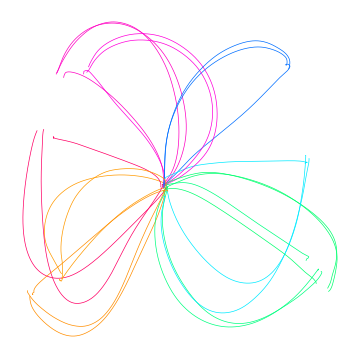

In [131]:
## Plot trial-averaged reaches

# Find unique conditions
conds = dataset.trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()

# Initialize plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond in conds:
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # Extract trial data
    trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450), ignored_trials=(~mask))
    # Average hand position across trials
    traj = trial_data.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
    reach_angle = np.arctan2(*active_target[::-1])
    # Plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))

plt.axis('off')
plt.show()

### **Step 4:** Split dataset into Train and Validation


In [153]:
trial_num = inputs.shape[0]
assert outputs.shape[0] == trial_num, \
        'Numbers of trials in inputs and outputs do not match'
perc_train, perc_valid = 80,20 
assert perc_train + perc_valid == 100, 'Train + Valid != 100%'
n_train = np.round(trial_num/100*perc_train).astype(int)
n_valid = np.round(trial_num/100*perc_valid).astype(int)

np.random.seed(42)
idxs = np.random.permutation(trial_num)
train_idxs, valid_idxs = idxs[:n_train], idxs[n_train:]
train_input,  valid_input  = Tensor(inputs[train_idxs]),  Tensor(inputs[valid_idxs])
train_output, valid_output = Tensor(outputs[train_idxs]), Tensor(outputs[valid_idxs]) 

In [204]:
import h5py

data = h5py.File(f'neural_BLAD.h5', 'r')
train_input = Tensor(data['train_data'][:]) #(num_trials, len_trial, num_neurons)
valid_input = Tensor(data['valid_data'][:])
train_output = Tensor(data['train_full_behavior'][:]) #(num_trials, len_trial, num_neurons)
valid_output = Tensor(data['valid_full_behavior'][:])

input_size = train_input.shape[-1]
output_size = train_output.shape[-1]

# print(data.keys())

### **Step 4:** Decode hand kinematics

### *Think!* Do you know the difference between *dynamics* and *kinematics*?

Answer: WRITE

### **Expercise 3.2A:** Construct an RNN decoder class

In [236]:
class RNN_Decoder(nn.Module):
  '''
  This RNN Decoder should decode some behavioral variables
  from spike trains is a sequence-to-sequence manner
  Inputs
  ------
    spikes: torch.Tensor [trials x time x neurons]
  Output
  ------
    behaviors: torch.Tensor [trials x time x behavioral dimensions]
  '''
  def __init__(self, input_size, output_size, rnn_units = 256,
               hidden_units=1024, 
               num_layers=1, dropout_rate=0.05):
    super(RNN_Decoder, self).__init__()
      ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("RNN Decoder")
    ####################################################################
    self.rnn_units = rnn_units # 2REMOVE
    self.num_layers = num_layers
    self.rnn = nn.LSTM(input_size, rnn_units, num_layers=num_layers, 
                      batch_first=True, bidirectional=True) # 2REMOVE
    self.readout = nn.Sequential(
                      # nn.BatchNorm1d(rnn_units),
                      nn.Linear(rnn_units, hidden_units), # 2REMOVE sizes
                      nn.ReLU(),
                      # nn.BatchNorm1d(hidden_units),
                      nn.Dropout(p=dropout_rate), # 2REMOVE
                      nn.Linear(hidden_units, output_size,bias=False) # 2REMOVE sizes
                    )

  def forward(self, inputs):
    h_t, h_n = self.rnn(inputs)
    h_uni = (h_t[:, :, :self.rnn_units] + h_t[:, :, self.rnn_units:])/2
    # print(inputs.shape,h_uni.shape)
    output = self.readout(h_uni)
    return output#.reshape((*inputs.shape[:2],-1))

# ## Uncomment to test
# decoder = RNN_Decoder(10,10) # WRITE UNIT TESTS (dr=1, dr=0)
# print(decoder)

decoder = RNN_Decoder(input_size,output_size)
print(decoder)
# assert decoder(torch.Tensor(input)).shape == output.shape, \
#         "RNN output shape does not match the desired output shape"

# Hidden HINT:
# 1. Check the required dimensions of the data. 
# How to make nn.RNN follow the same convention?

RNN_Decoder(
  (rnn): LSTM(207, 256, batch_first=True, bidirectional=True)
  (readout): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=1024, out_features=2, bias=False)
  )
)


In [220]:
# train_output.dtype
# help(nn.MSELoss)
# train_output[:]



In [1]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001, weight_decay=1e-4)
loss = nn.MSELoss()

batch = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = TensorDataset(train_input.to(DEVICE).float(), 
                              train_output.to(DEVICE).float())
valid_dataset = TensorDataset(valid_input.to(DEVICE).float(), 
                              valid_output.to(DEVICE).float())
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch, shuffle=False)

decoder = RNN_Decoder(input_size,output_size).to(DEVICE)

max_epoch = 1000
train_losses, valid_losses = [], []
for epoch in tqdm(range(max_epoch)):
  # Train
  # decoder.train()
  train_loss, valid_loss = [], []
  for input, output in train_dataloader:
    optimizer.zero_grad()
    pred_output = decoder(input)
    L = loss(pred_output,output)
    L.backward()
    optimizer.step()

  train_loss.append(L.detach().cpu())
  # Validate
  # decoder.eval()
  # for input, output in valid_dataloader:
  #   pred_output = decoder(input)
  #   L = loss(pred_output,output)
  #   valid_loss.append(L.detach().cpu())
  
  train_losses.append(np.mean(train_loss))
  # valid_losses.append(np.mean(valid_loss))

  if epoch % 100 ==0:
    print("Train loss: ",train_losses[-1])#,", valid loss: ",valid_losses[-1])

plt.figure()
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

NameError: ignored

torch.Size([74, 95, 207]) torch.Size([74, 95, 256])


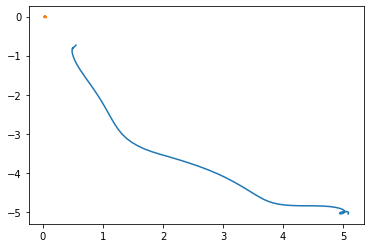

In [234]:
pred_vel = decoder(Tensor(valid_input).to(DEVICE)).detach().cpu().numpy()

# pred_vel.shape

plt.plot(*valid_output[0].T)
plt.plot(*pred_vel[0].T)

In [82]:
## Kinematic decoding

pred_vel = decoder(Tensor(inputs).to(DEVICE)).detach().cpu().numpy()

# Fit and evaluate decoder
# gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
# gscv.fit(rates, vel)
# pred_vel = gscv.predict(rates)
# print(f"Decoding R2: {gscv.best_score_}")

# Merge predictions back to continuous data
print(pred_vel.shape,outputs.shape)
pred_vel_df = pd.DataFrame(pred_vel.reshape((-1,output_size)), 
                           index=lagged_trial_data.clock_time, 
                           columns=pd.MultiIndex.from_tuples(
                               [('pred_vel', 'x'), ('pred_vel', 'y')]))
dataset.data = pd.concat([dataset.data, pred_vel_df], axis=1)

RuntimeError: ignored

In [39]:
del(dataset.data['pred_vel'])

/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


KeyError: ignored

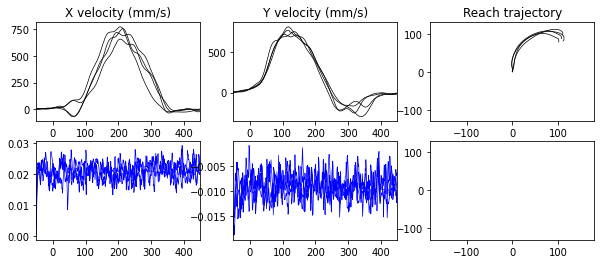

In [41]:
## Plot predicted vs true kinematics

# Choose 23rd condition to plot
cond = conds[23]

# Find trials in condition and extract data
mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450), ignored_trials=(~mask))

# Initialize figure
fig, axs = plt.subplots(2, 3, figsize=(10, 4))
t = np.arange(-50, 450, dataset.bin_width)

# Loop through trials in condition
for _, trial in trial_data.groupby('trial_id'):
    # True and predicted x velocity
    axs[0][0].plot(t, trial.hand_vel.x, linewidth=0.7, color='black')
    axs[1][0].plot(t, trial.pred_vel.x, linewidth=0.7, color='blue')
    # True and predicted y velocity
    axs[0][1].plot(t, trial.hand_vel.y, linewidth=0.7, color='black')
    axs[1][1].plot(t, trial.pred_vel.y, linewidth=0.7, color='blue')
    # True and predicted trajectories
    true_traj = np.cumsum(trial.hand_vel.to_numpy(), axis=0) * dataset.bin_width / 1000
    pred_traj = np.cumsum(trial.pred_vel.to_numpy(), axis=0) * dataset.bin_width / 1000
    axs[0][2].plot(true_traj[:, 0], true_traj[:, 1], linewidth=0.7, color='black')
    axs[1][2].plot(pred_traj[:, 0], pred_traj[:, 1], linewidth=0.7, color='blue')

# Set up shared axes
for i in range(2):
    axs[i][0].set_xlim(-50, 450)
    axs[i][1].set_xlim(-50, 450)
    axs[i][2].set_xlim(-180, 180)
    axs[i][2].set_ylim(-130, 130)

# Add labels
axs[0][0].set_title('X velocity (mm/s)')
axs[0][1].set_title('Y velocity (mm/s)')
axs[0][2].set_title('Reach trajectory')
plt.show()


## **Exercise 3.3** Auto-encoding sequential neural data with RNN-based LFADS model 

## **Exercise 3.4\*:** Non-autonomous LFADS: identifiability of control inputs



# References

1. Izhikevich, Eugene M. Dynamical systems in neuroscience. MIT press, 2007.